# Comparing Permutation and Bootstrap

In this notebook we compare the permutation and bootstrap JER control methods in the two sample case.

In [1]:
import numpy as np
import numpy.matlib as npm
import sys
import matplotlib.pyplot as plt 

import sanssouci as sa

import pyrft as pr
import random

### Initialize the example (using the equi-corr example here)

In [2]:
random.seed(a=2021)

m = 2000                    # number of variables     (eg : number of voxels in an image)
n = 80                      # number of observations  (eg : number of images)
pi0 = 0.99                  # proportion of noise (true null hypotheses)
p0 = int(np.round(pi0 * m)) # number of true null hypotheses (non active voxels)
rho = 0.3                   # equi-correlation
s = 1                       # signal to noise ratio (because sigma is 1 CHECK!)

# generate noise
Z = np.random.randn(n, m)
w = np.random.randn(n)
W = Z.copy()
for i in range(m):
  W[:, i] = w # W has the same w for each subject to ensure the dependence
Y = np.sqrt(1 - rho) * Z + np.sqrt(rho) * W

# add signal (for false null hypotheses)
categ = np.random.binomial(1, 0.5, size=n) # Equal probability of each - but ususally not balanced in fact!
data = Y.copy()
w1 = np.where(categ == 1)
# Add signal to the data when the category is 1! :)
data[w1, (p0 + 1):m] = Y[w1, (p0 + 1): m] + s

# Record where the signal is as a boolean vector
bool_signal = np.ones((m, 1)) == 0
bool_signal[(p0 + 1): m] = True
sum(bool_signal)

array([19])

### JER control using permutation

In [3]:
# Initialize the number of bootstraps and the alpha level
B = 100
alpha = 0.1
pval0 = sa.get_perm_p(data, categ, B=B , row_test_fun=sa.row_welch_tests)
piv_stat = sa.get_pivotal_stats(pval0, K=m)
lambda_perm = np.quantile(piv_stat, alpha)

print('Lambda Perm:', lambda_perm)
thr_perm = sa.t_linear(lambda_perm, np.arange(1, m + 1), m)

Lambda Perm: 0.17236806157785445


### JER control using bootstrap

In [4]:
# Generate the design matrix from the category vector
X = pr.group_design(categ); 

# Set the contrast matrix
C = np.array([1, -1]); 

# Run the bootstrap JER algorithm
minPperm, orig_pvalues, pivotal_stats, bs = pr.boot_contrasts(data.transpose(), X, C, B)

# Obtain the lambda calibration
lambda_boot = np.quantile(pivotal_stats, alpha)
print('Lambda Boot:', lambda_boot)

thr_boot = sa.t_linear(lambda_boot, np.arange(1, m + 1), m)

Lambda Boot: 0.1720388225910474


(array([57., 12., 12.,  3.,  6.,  5.,  0.,  3.,  0.,  2.]),
 array([6.67407898e-08, 1.99158184e-03, 3.98309694e-03, 5.97461204e-03,
        7.96612715e-03, 9.95764225e-03, 1.19491573e-02, 1.39406724e-02,
        1.59321876e-02, 1.79237027e-02, 1.99152178e-02]),
 <a list of 10 Patch objects>)

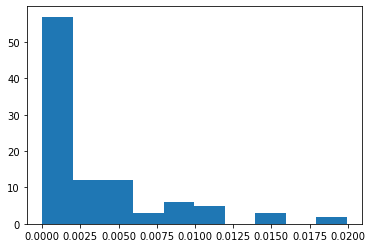

In [5]:
import matplotlib.pyplot as plt 
plt.hist(minPperm)

Calculate the p-values (note that the bootstrap and permutation methods as coded use different two sample test so the p-values are slightly different)

In [6]:
rwt = sa.row_welch_tests(data, categ)
pvals_perm = rwt['p_value']
print(pvals_perm.shape)
pval_sort_idx_perm = np.argsort(pvals_perm)

pval_sort_idx_boot = np.argsort(np.ravel(orig_pvalues.field))
pvals_boot = np.ravel(orig_pvalues.field)[pval_sort_idx_boot]

(2000,)


In [9]:
pvals_boot

array([6.67407898e-08, 1.93635111e-07, 1.94423402e-07, ...,
       9.97127197e-01, 9.98931706e-01, 9.98973585e-01])

### Compare permutation and bootstrap p-values

The p values are very close between the two methods (with use different 2 sample tests) but are slightly different, especially in the tails

[0.03247533 0.97933297 0.59796329 0.94204189 0.2767466  0.38967197
 0.84673441 0.01325814 0.05675138 0.28444079]
[5.61548585e-11 2.86722202e-10 3.66596531e-10 5.21172883e-10
 1.71791337e-09 1.04356601e-08 1.51298616e-08 2.25915850e-08
 3.08375017e-08 3.89408796e-08]
[0.61238534 0.00709827 0.05340741 0.0684976  0.54325549 0.28449149
 0.80367945 0.03700122 0.01571187 0.10648225]
[0.25240828 0.25315707 0.25386105 0.25489101 0.25569662 0.25624043
 0.25695789 0.25760985 0.25772658 0.25785108]


Text(0.5, 1.0, 'Comparing the p-values from the two methods')

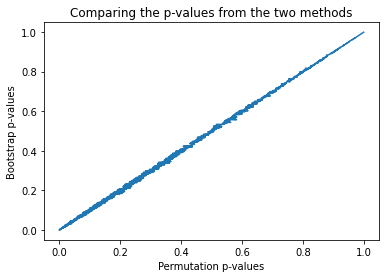

In [27]:
print(pvals_perm[0: 10])
print(pvals_boot[0: 10])
print(pvals_perm[1000: 1010])
print(pvals_boot[1000: 1010])

plt.plot(pvals_perm[pval_sort_idx_boot], pvals_boot)
plt.xlabel('Permutation p-values')
plt.ylabel('Bootstrap p-values')
plt.title('Comparing the p-values from the two methods')

### Generate a histogram of the p-values

Note that for low numbers of voxels this is not uniform because the data is highly correlated

(array([557., 317., 227., 200., 138., 127., 118., 102., 120.,  94.]),
 array([1.74714687e-10, 9.98266716e-02, 1.99653343e-01, 2.99480014e-01,
        3.99306686e-01, 4.99133357e-01, 5.98960028e-01, 6.98786700e-01,
        7.98613371e-01, 8.98440043e-01, 9.98266714e-01]),
 <BarContainer object of 10 artists>)

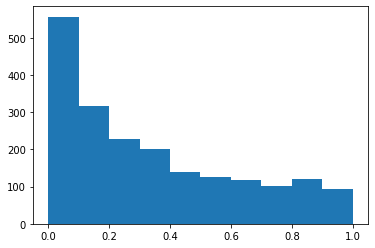

In [28]:
plt.hist(pvals_perm)

### Plot the FPR and TP curve bounds

The input p-values were not sorted -> this is done now


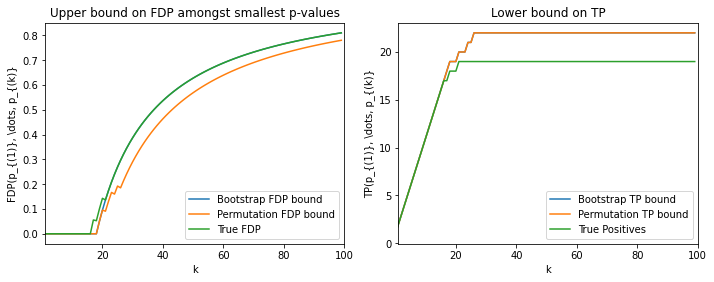

In [29]:
max_FP_perm = sa.curve_max_fp(pvals_perm, thr_perm)
max_FP_boot = sa.curve_max_fp(pvals_boot, thr_boot)

# Generate the vector [0,...,m]
one2npvals = np.arange(1, m + 1)

# Choose the number of p-values (always the smallest ones first) to plot
lowestnumber = 100

# Ensure that selected number is not greater than the total number of p-values
lowestnumber = np.min([lowestnumber, m])

# Dividing the envelope by the number of elements in the set gives a bound on the false discovery proportion
max_FDP_boot = max_FP_boot[0: lowestnumber] / one2npvals[0: lowestnumber] 
min_TP_boot  = one2npvals[0: lowestnumber] - max_FP_boot[0: lowestnumber]
max_FDP_perm = max_FP_perm[0: lowestnumber] / one2npvals[0: lowestnumber] 
min_TP_perm  = one2npvals[0: lowestnumber] - max_FP_perm[0: lowestnumber]

# Calculate the truth (to determine if it is correctly bounded!)
sorted_signal = bool_signal[pval_sort_idx_boot]
TP = np.zeros(lowestnumber)
for I in np.arange(lowestnumber):
    TP[I] = np.sum(sorted_signal[0: I + 1])
    
# Calculate the true FDP for each subset
FP = np.zeros(lowestnumber)
for I in np.arange(lowestnumber):
    FP[I] = np.sum(abs(sorted_signal[0: I + 1] - 1))
true_FDP = FP / one2npvals[0: lowestnumber] 
    
# Initialize the figure
figure = plt.figure(figsize=(10, 4))

# Plot the false discovery proportion and its bound
plt.subplot(121)
plt.plot(max_FDP_boot, label = 'Bootstrap FDP bound')
plt.plot(max_FDP_perm, label = 'Permutation FDP bound')
plt.plot(true_FDP, label = 'True FDP')
plt.title('Upper bound on FDP amongst smallest p-values')
plt.xlim(1, lowestnumber)
plt.xlabel('k')
plt.ylabel('FDP(p_{(1)}, \dots, p_{(k)}')
plt.legend(loc="lower right")

# Plot the true postives and their bound
plt.subplot(122)
plt.plot(min_TP_perm, label = 'Bootstrap TP bound')
plt.plot(min_TP_perm, label = 'Permutation TP bound')
plt.plot(TP, label = 'True Positives')
plt.title('Lower bound on TP')
plt.legend(loc="lower right")
plt.xlim(1, lowestnumber)
plt.xlabel('k')
plt.ylabel('TP(p_{(1)}, \dots, p_{(k)}')
#figure, axes = plt.subplots(nrows=1, ncols=2) 
figure.tight_layout(pad=1.0)

### Analyzing the impact of lambda changes on the FDP curve

Suprisingly the value of lambda doesn't appear to make much of a difference!

Lambda Perm: 0.1923383512152377
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now


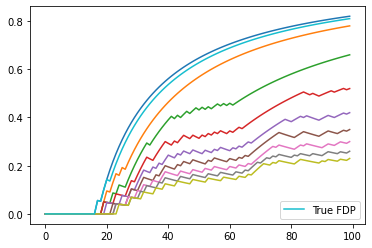

In [30]:
# Initialize the number of bootstraps and the alpha level
B = 100
alpha = 0.1
pval0 = sa.get_perm_p(data, categ, B=B , row_test_fun=sa.row_welch_tests)
piv_stat = sa.get_pivotal_stats(pval0, K=m)
lambda_perm = np.quantile(piv_stat, alpha)

print('Lambda Perm:', lambda_perm)
thr_perm = sa.t_linear(lambda_perm, np.arange(1, m + 1), m)

n2use = 100
lambda_set = np.arange(10) / 10
print(lambda_set)
lambda_set = lambda_set[1:]
for I in np.arange(len(lambda_set)):
    thresh = sa.t_linear(lambda_set[I], np.arange(1, m + 1), m)
    max_FP_perm = sa.curve_max_fp(pvals_perm, thresh)
    max_FDP_perm = max_FP_perm[0:n2use]/one2npvals[0: n2use] 
    plt.plot(max_FDP_perm)
plt.plot(true_FDP[0: n2use], label = 'True FDP')
plt.legend(loc="lower right")

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now


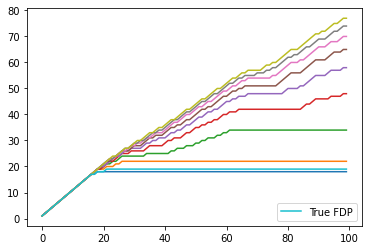

In [31]:
lambda_set = np.arange(10) / 10
lambda_set = lambda_set[1:]
print(lambda_set)
n2use = 100
for I in np.arange(len(lambda_set)):
    thresh = sa.t_linear(lambda_set[I], np.arange(1, m + 1), m)
    max_FP_perm = sa.curve_max_fp(pvals_perm, thresh)
    min_TP_perm = np.arange(1, m + 1) - max_FP_perm
    plt.plot(min_TP_perm[0: n2use])
plt.plot(TP[0: n2use], label = 'True FDP')
plt.legend(loc="lower right")

Analyzing for very low lambda

The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now


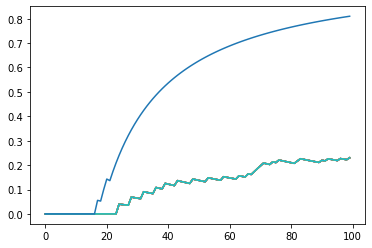

In [32]:
lambda_set = np.arange(10) / 10000
for I in np.arange(len(lambda_set)):
    thresh = sa.t_linear(lambda_set[I], np.arange(1, m + 1), m)
    max_FP_perm = sa.curve_max_fp(pvals_perm, thresh)
    plt.plot(max_FDP_perm)
plt.plot(true_FDP, label = 'True FDP')

## One Sample Example

In [33]:
random.seed(a=2021)

m = 2000                    # number of variables     (eg : number of voxels in an image)
n = 80                      # number of observations  (eg : number of images)
pi0 = 0.99                  # proportion of noise (true null hypotheses)
p0 = int(np.round(pi0 * m)) # number of true null hypotheses (non active voxels)
rho = 0.3                   # equi-correlation

# generate noise
Z = np.random.randn(n, m)
w = np.random.randn(n)
W = Z.copy()
for i in range(m):
  W[:, i] = w # W has the same w for each subject to ensure the dependence
Y = np.sqrt(1 - rho) * Z + np.sqrt(rho) * W

# add signal (for false null hypotheses)
categ = np.zeros(n) # Equal probability of each - but ususally not balanced in fact!
data = Y.copy()

### Running bootstrap procedure

In [34]:
# Generate the design matrix from the category vector
X = pr.group_design(categ)

# Set the contrast matrix
C = np.array(1)

B = 100; alpha = 0.1

# Run the bootstrap JER algorithm
minPperm, orig_pvalues, pivotal_stats, _ = pr.boot_contrasts(data.transpose(), X, C, n_bootstraps = B)

# Obtain the lambda calibration
lambda_boot = np.quantile(pivotal_stats, alpha)
print('Lambda Boot:', lambda_boot)

thr_boot = sa.t_linear(lambda_boot, np.arange(1, m + 1), m)

Lambda Boot: 0.10593608650548703


In [35]:
print(len(pivotal_stats))

100


In [36]:
# Running permutation procedure

In [37]:
# Initialize the number of bootstraps and the alpha level
B = 100
alpha = 0.1
pval0 = sa.get_permuted_p_values_one_sample(data, B=1000)
piv_stat = sa.get_pivotal_stats(pval0)
lambda_perm = np.quantile(piv_stat, alpha)

print('Lambda Perm:', lambda_perm)
thr_perm = sa.t_linear(lambda_perm, np.arange(1, m + 1), m)

Lambda Perm: 0.17913704536003008


In [38]:
thr_simes = sa.t_linear(alpha, np.arange(1, m + 1), m)
# sa.min_tp(cluster_p_values, thr)